In [1]:
import pandas as pd
import os
from sklearn import linear_model, datasets, preprocessing, metrics
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.feature_extraction import DictVectorizer
import numpy as np
from sklearn.model_selection import KFold
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv(os.path.join('train.csv'))
val = pd.read_csv(os.path.join('validation.csv'))
test = pd.read_csv(os.path.join('test.csv'))

In [3]:
def downsampling(data):
    data_no_click = data.query('click == 0')
    data_one_click = data.query('click == 1')
    sample_nums = len(data_one_click) * 700
    new_data_no_click = data_no_click.sample(n=sample_nums, random_state=42)
    return pd.concat([new_data_no_click, data_one_click])

In [4]:
# def hash_feature(row):
# #     row['keypage'] = hash(row['keypage'])
# #     row['slotid'] = hash(row['slotid'])
# #     row['creative'] = hash(row['creative'])
# #     row['domain'] = hash(row['domain'])
#     for user_tag in row['usertag'].split(','):
#         if 
#     return row

In [5]:
def create_freq_CTR_by_feature(data, column):
    new_features = data[[column, 'click']]
    new_features[column + '_freq'] = 1.0
    data_grouped = new_features.groupby(column)
    new_features = data_grouped.sum()
    new_features['click'] /= new_features[column + '_freq']
    new_features.rename(columns={'click' : column + '_CTR'}, inplace = True)
    return data.join(new_features, on=column)

In [6]:
def preprocess_data(data, enforce_cols=None):
    data = data.sort_index(axis=0)
    to_drop = ['userid', 'bidid', 'url', 'urlid', 'IP', 'keypage', 'slotid', 'creative', 'domain']
    data = data.drop(to_drop, axis=1)
  
    colums_split = data['useragent'].str.split('_', expand=True)
    data = data.join(colums_split.rename(columns={0:'os', 1:'browser'}))
#     data = data.apply(lambda row: hash_feature(row), axis=1)
    
    colums_split = data['usertag'].str.split(',')
    colums_split = colums_split.str.join('|').str.get_dummies()
    colums_split = colums_split.add_prefix('usertag_')
    data = data.join(colums_split)
    
#     data = data.join(colums_split)
    data.drop(['useragent', 'usertag'], axis=1, inplace=True)
    data.fillna("unknown", inplace=True)
    data = pd.get_dummies(data)

#     data = create_freq_CTR_by_feature(data, 'city')
#     data = create_freq_CTR_by_feature(data, 'region')    

    # match test set and training set columns
    if enforce_cols is not None:
    # enforce_cols is the columns of train set, to_drop and to_add finds the difference
        to_drop = np.setdiff1d(data.columns, enforce_cols)
        to_add = np.setdiff1d(enforce_cols, data.columns)
        data.drop(to_drop, axis=1, inplace=True)
        data = data.assign(**{c: 0 for c in to_add})
        
    data = data.reindex(sorted(data.columns), axis=1)
    return data

In [7]:
train_processed = downsampling(train.copy())
train_processed = preprocess_data(train_processed)
val_processed = preprocess_data(val.copy(), enforce_cols=train_processed.columns)
test_processed = preprocess_data(test.copy(), enforce_cols=train_processed.columns)

In [8]:
train_processed.head()

,adexchange_1.0,adexchange_2.0,adexchange_3.0,adexchange_4.0,adexchange_unknown,advertiser,bidprice,browser_chrome,browser_firefox,browser_ie,...,usertag_13874,usertag_14273,usertag_15398,usertag_16593,usertag_16617,usertag_16661,usertag_16706,usertag_16751,usertag_16753,weekday
0,0,1,0,0,0,3427,238,0,0,1,...,0,0,0,0,0,0,0,0,0,5
1,1,0,0,0,0,2821,294,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,3427,238,0,0,1,...,0,0,0,0,0,0,0,0,0,3
3,1,0,0,0,0,1458,300,0,0,1,...,0,0,0,0,0,0,0,0,0,6
5,1,0,0,0,0,1458,300,0,0,1,...,0,0,0,0,0,0,0,0,0,4


In [9]:
train_x = train_processed.drop(['bidprice', 'payprice', 'click'], axis=1)
train_y = train_processed['click']
val_x = val_processed.drop(['bidprice', 'payprice', 'click'], axis=1)
val_y = val_processed['click']
test_x = test_processed.drop(['bidprice', 'payprice', 'click'], axis=1)

In [10]:
# Caculate the root mean square error
def rmse(preds, dtrain):
    labels = dtrain.get_label()
    diff = preds - labels                       
    mean_diff_squared = (diff ** 2).mean()  
    error = np.sqrt(mean_diff_squared)
    return error 

In [11]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

def KFold_model(trainX, trainY, test, **kwargs):
    trainX = np.array(trainX)
    trainY = np.array(trainY)
    test = np.array(test)
    
    K = 5
    kfold = KFold(n_splits=K, random_state=7,shuffle = True)

    xgb_preds = []
    val_scores = []
    
    for train_index, val_index in kfold.split(trainX):
        
        train_X, valid_X = trainX[train_index], trainX[val_index]
        train_y, valid_y = trainY[train_index], trainY[val_index]
        xgb_params = {'eta': 0.3, 'max_depth': 3, 'subsample': 1.0
                      , 'colsample_bytree': 1.0, 'objective': 'reg:logistic'
                      , 'eval_metric': 'rmse', 'seed': 99, 'silent': True}

        d_train = xgb.DMatrix(train_X, train_y)
        d_valid = xgb.DMatrix(valid_X, valid_y)
        d_test = xgb.DMatrix(test)

        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        model = xgb.train(xgb_params, d_train, 500,  watchlist, maximize=False, 
                              verbose_eval=50, early_stopping_rounds=50)
        
        val_score = rmse(model.predict(d_valid, ntree_limit=model.best_ntree_limit), d_valid)
        print("The validation set score is :\t{}\n".format(val_score))
        val_scores.append(val_score)
        
        xgb_pred = model.predict(d_test)
        xgb_preds.append(list(xgb_pred))
        
    print(val_scores)
    
    preds = []
    for i in range(len(xgb_preds[0])):
        sumres = 0
        for j in range(K):
            sumres += xgb_preds[j][i]
        preds.append(sumres / K)
    
    return preds

In [12]:
val_pred = KFold_model(train_x, train_y, val_x)

[0]	train-rmse:0.355247	valid-rmse:0.355235
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.034734	valid-rmse:0.034684
[100]	train-rmse:0.034161	valid-rmse:0.034501
[150]	train-rmse:0.033733	valid-rmse:0.0342
[200]	train-rmse:0.033375	valid-rmse:0.03407
[250]	train-rmse:0.03307	valid-rmse:0.034056
Stopping. Best iteration:
[217]	train-rmse:0.033202	valid-rmse:0.033992

The validation set score is :	0.033991701900959015

[0]	train-rmse:0.355237	valid-rmse:0.35526
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.03483	valid-rmse:0.03528
[100]	train-rmse:0.034104	valid-rmse:0.034542
[150]	train-rmse:0.033723	valid-rmse:0.034409
[200]	train-rmse:0.033414	valid-rmse:0.034234
[250]	train-rmse:0.0331	valid-rmse:0.034092
Stopping. Best iteration:
[236]	train-rmse:0.033

In [13]:
# w = len(train_y.to_frame().query('click == 0')) / len(train.query('click == 0'))
# print(w)

In [14]:
# sum([x / (x + (1 - x) / w) for x in val_pred]) / len(val_x)

In [15]:
rmse(val_pred, xgb.DMatrix(val_x, val_y))

0.023861021032229906

In [16]:
sum([x for x in val_pred]) / len(val_x)

0.0012569717924801743

In [17]:
CTR = sum(val_y) / len(val_x)
print(CTR)

0.0006646376573167722


In [18]:
avgCTR = sum(train['click']) / len(train)
print(avgCTR)

0.0007375623256619447


In [19]:
def compare_performance(metrics_list, best_metrics):
    return metrics_list[0] >= best_metrics[0] and metrics_list[1] >= best_metrics[1]

In [20]:
new_val = val.copy()

results = []
click_list = []
CTR_list = []
cost_list = []
base_bid_list = list(range(74, 75))
last_paided_index = 0

for base_bid in base_bid_list:
    bidprices = [x * base_bid / avgCTR for x in val_pred]
    new_val['bidprice'] = bidprices
    new_val.loc[new_val.advertiser == 2259, 'bidprice'] = 5
    new_val.loc[new_val.advertiser == 2261, 'bidprice'] = 5
    budget = 6250
    suc_bids = new_val.query('bidprice >= payprice and bidprice >= slotprice')
    cost = 0
    clicks = 0
    imps = 0
    i = 0
    
    for index, row in suc_bids.iterrows():
        if cost <= budget:
            cost += row['payprice'] / 1000
            clicks += row['click']
            imps += 1
            i += 1
            last_paided_index = max(last_paided_index, i)
            
    CTR = clicks / imps * 100
    CTR_list.append(CTR * 1000)
    click_list.append(clicks)
    cost_list.append(cost / 100)
    
    eCPC = cost / clicks if clicks > 0 else float('inf')
    metrics_list = [clicks, CTR, cost, cost / imps * 1000, eCPC]
    results.append([base_bid, clicks, CTR, cost, cost / imps * 1000, eCPC])
    
results = pd.DataFrame(results)
results = results.rename(columns={0: "base_bid", 1: "clicks",
    2: "CTR", 3: "cost", 4: "avg CPM", 5: "eCPC"})
results.to_csv(os.path.join('linear_bid_xgboost.csv'), index=False)

In [21]:
results.loc[results.clicks == max(results['clicks'])]

,base_bid,clicks,CTR,cost,avg CPM,eCPC
0,74,165,0.136508,6129.015,50.706657,37.145545


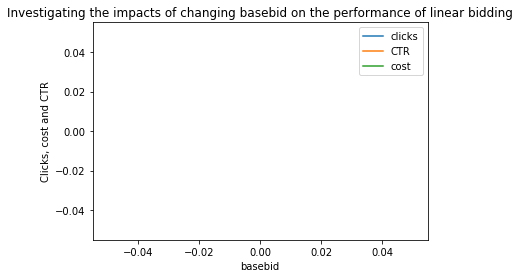

In [22]:
ys = [click_list[30:], CTR_list[30:], cost_list[30:]]
labels = ['clicks', 'CTR', 'cost']

for y, label in zip(ys, labels):
    plt.plot(base_bid_list[30:], y, label=label)
plt.legend()
plt.xlabel('basebid')
plt.ylabel('Clicks, cost and CTR')
plt.title('Investigating the impacts of changing basebid on the performance of linear bidding')
plt.show()

In [23]:
"""
Computes some basic statistics based on provided dataset such as Clicks, Imps and CTR.
"""
def calc_statistics(data):
    cols = data[['click', 'advertiser', 'payprice']]
    grouped_cols = cols.groupby('advertiser')
    new_features = grouped_cols.count()
    new_features['Imps'] = new_features['click']

    new_features.rename(columns={'click':'Clicks', 'payprice':'Cost'}, inplace = True)

    new_features[['Clicks', 'Cost']] = grouped_cols.sum()[['click', 'payprice']]
    new_features['Cost'] = new_features['Cost'] / 1000

    new_features[['Avg CPM']] = grouped_cols.mean()[['payprice']]
    new_features['CTR'] = new_features['Clicks'] / new_features['Imps'] * 100
    new_features['eCPC'] = new_features['Cost'] / new_features['Clicks']

    new_features = new_features.reindex(sorted(new_features.columns), axis=1)
    return new_features

In [24]:
sum(suc_bids[:last_paided_index]['click'])

165

In [25]:
suc_bids_statistics = calc_statistics(suc_bids[:last_paided_index])
print(suc_bids_statistics)
print('clicks: ' + str(sum(suc_bids_statistics['Clicks'])))

              Avg CPM       CTR  Clicks      Cost   Imps       eCPC
advertiser                                                         
1458        38.473183  0.211457      44   800.550  20808  18.194318
2259         4.481481  0.000000       0     2.420    540        inf
2261         3.861202  0.000000       0     3.533    915        inf
2821        53.845269  0.090040      13   777.418  14438  59.801385
2997        62.556674  0.422215      26   385.224   6158  14.816308
3358        53.474378  0.174129      21   644.901  12060  30.709571
3386        56.153401  0.058423      21  2018.434  35945  96.115905
3427        49.572383  0.181098      32   875.944  17670  27.373250
3476        50.299157  0.064840       8   620.591  12338  77.573875
clicks: 165


In [26]:
submission = val.copy()[['advertiser', 'bidid']]
submission['click'] = val_pred
submission.set_index(['bidid'], inplace=True)
submission.drop('advertiser', axis=1, inplace=True)
submission.to_csv('xgboost_val.csv')

In [27]:
# val_click_0 = new_val.query('advertiser == 2821 and click == 0')[['click', 'bidprice', 'payprice']]
# val_click_1 = new_val.query('advertiser == 2821 and click == 1')[['click', 'bidprice', 'payprice']]

In [28]:
# val_click_1.query('bidprice < payprice')

In [29]:
# val_click_0.query('bidprice >= payprice').head()

In [30]:
# len(val_click_0.query('bidprice >= payprice'))

In [31]:
val_statistics = calc_statistics(val)
print(val_statistics)
print('clicks: ' + str(sum(val_statistics['Clicks'])))

              Avg CPM       CTR  Clicks      Cost   Imps        eCPC
advertiser                                                          
1458        68.875627  0.078585      49  4294.602  62353   87.644939
2259        93.856297  0.011965       2  1568.808  16715  784.404000
2261        89.658745  0.022140       3  1214.876  13550  404.958667
2821        90.363355  0.086783      23  2394.900  26503  104.126087
2997        62.950777  0.420984      26   388.784   6176   14.953231
3358        84.824099  0.069826      23  2794.021  32939  121.479174
3386        76.780958  0.049413      28  4350.793  56665  155.385464
3427        75.259251  0.073730      37  3776.735  50183  102.073919
3476        77.077083  0.028321      11  2993.751  38841  272.159182
clicks: 202


In [32]:
test_pred = KFold_model(train_x, train_y, test_x)

[0]	train-rmse:0.355247	valid-rmse:0.355235
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.034734	valid-rmse:0.034684
[100]	train-rmse:0.034161	valid-rmse:0.034501
[150]	train-rmse:0.033733	valid-rmse:0.0342
[200]	train-rmse:0.033375	valid-rmse:0.03407
[250]	train-rmse:0.03307	valid-rmse:0.034056
Stopping. Best iteration:
[217]	train-rmse:0.033202	valid-rmse:0.033992

The validation set score is :	0.033991701900959015

[0]	train-rmse:0.355237	valid-rmse:0.35526
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.03483	valid-rmse:0.03528
[100]	train-rmse:0.034104	valid-rmse:0.034542
[150]	train-rmse:0.033723	valid-rmse:0.034409
[200]	train-rmse:0.033414	valid-rmse:0.034234
[250]	train-rmse:0.0331	valid-rmse:0.034092
Stopping. Best iteration:
[236]	train-rmse:0.033

In [33]:
best_base_bid = 74
submission = test.copy()[['advertiser', 'bidid']]
bidprices = np.asarray([x * best_base_bid / avgCTR for x in test_pred])
submission['bidprice'] = bidprices
submission.set_index(['bidid'], inplace=True)
submission.loc[submission.advertiser == 2259, 'bidprice'] = 5
submission.loc[submission.advertiser == 2261, 'bidprice'] = 5
submission.drop('advertiser', axis=1, inplace=True)
submission.to_csv('Group_5.csv')